In [1]:
import os, sys, math, logging, random
from pathlib import Path

import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import yamlu

from pybpmn.parser import BpmnParser, InvalidBpmnException
from yamlu.img import AnnotatedImage, Annotation

In [84]:
bpmn_paths = yamlu.glob(Path.home() / "ws" / "sapsam" / "sapsam-6k", "*.bpmn")
len(bpmn_paths)

5989

In [85]:
import sys
from tqdm import tqdm
from pybpmn.parser import BpmnParser, InvalidBpmnException
from pybpmn import syntax

logging.getLogger("pybpmn").setLevel("INFO")
parser = BpmnParser(link_pools=False, link_lanes=False)

records = []
for p in tqdm(bpmn_paths):
    try:
        anns = parser.parse_bpmn_anns(p)
        records.append({
            "fname": p.name, 
            "has_error": False,
            "shapes": len([a for a in anns if a.category in set(syntax.BPMNDI_SHAPE_CATEGORIES)]),
            "edges": len([a for a in anns if a.category in set(syntax.BPMNDI_EDGE_CATEGORIES)]),
        })
    except InvalidBpmnException as e:
        records.append({"fname": p.name, "has_error": True, "error_type": e.error_type, "error_details": e.details})
    except Exception as e:
        r = {"fname": p.name, "has_error": True, "error_type": type(e).__name__, "error_details": str(e)}
        print(r)
        records.append(r)

df = pd.DataFrame.from_records(records).set_index("fname")
df[["shapes", "edges"]] = df[["shapes", "edges"]].fillna(-1, downcast="infer")
print(yamlu.bin_stats(df.has_error))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5989/5989 [00:13<00:00, 451.41it/s]

559/5989 (9.33%)


In [86]:
df.error_type.value_counts()

sequenceFlow has no targetRef attrib                              158
sequenceFlow has no sourceRef attrib                              157
association has no targetRef attrib                                73
messageFlow has no sourceRef attrib                                56
association has no sourceRef attrib                                51
messageFlow has no targetRef attrib                                43
Duplicate model element id                                          9
Invalid endEvent with multiple event definitions                    6
Invalid intermediateThrowEvent with multiple event definitions      3
Invalid boundaryEvent with multiple event definitions               2
BPMN Choreography diagrams are not implemented.                     1
Name: error_type, dtype: int64

In [88]:
df_no_err = df.query("not has_error").copy()
df_no_err.describe()

,shapes,edges
count,5430.000000,5430.000000
mean,21.703499,21.378085
std,17.066914,18.714020
min,0.000000,0.000000
25%,15.000000,13.000000
50%,20.000000,19.000000
75%,23.000000,25.000000
max,357.000000,397.000000


In [89]:
df_no_err.shapes.value_counts().sort_index().head(10)

0    135
1     14
2     13
3     24
4     49
5     74
6     70
7     93
8    118
9    162
Name: shapes, dtype: int64

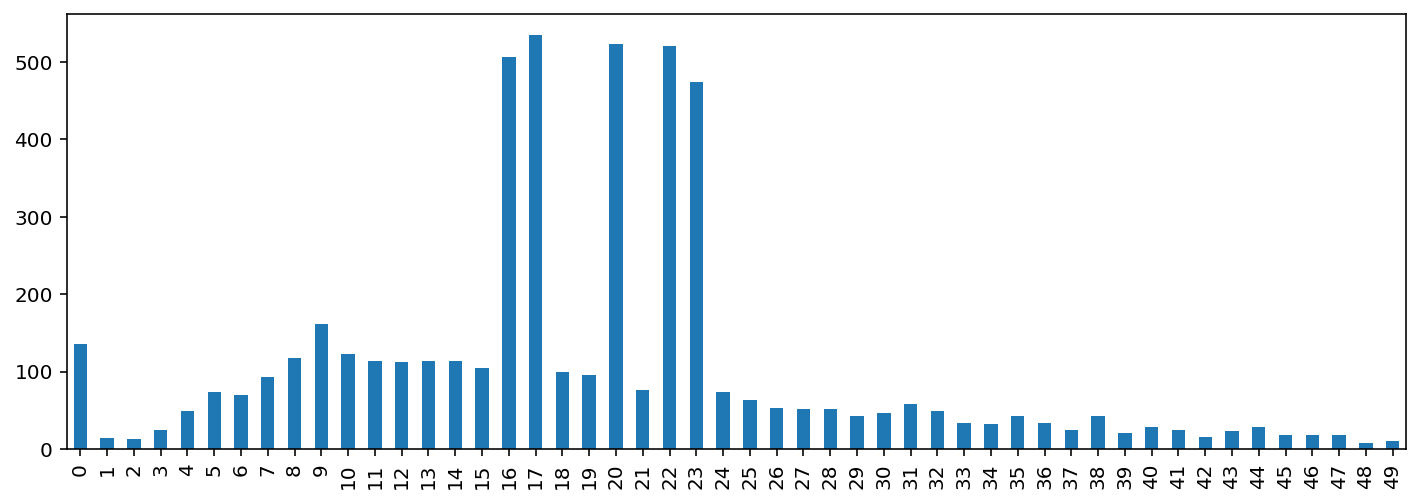

In [90]:
plt.figure(figsize=(12,4))
df_no_err.shapes.value_counts().reindex(np.arange(50)).plot.bar(ax=plt.gca());

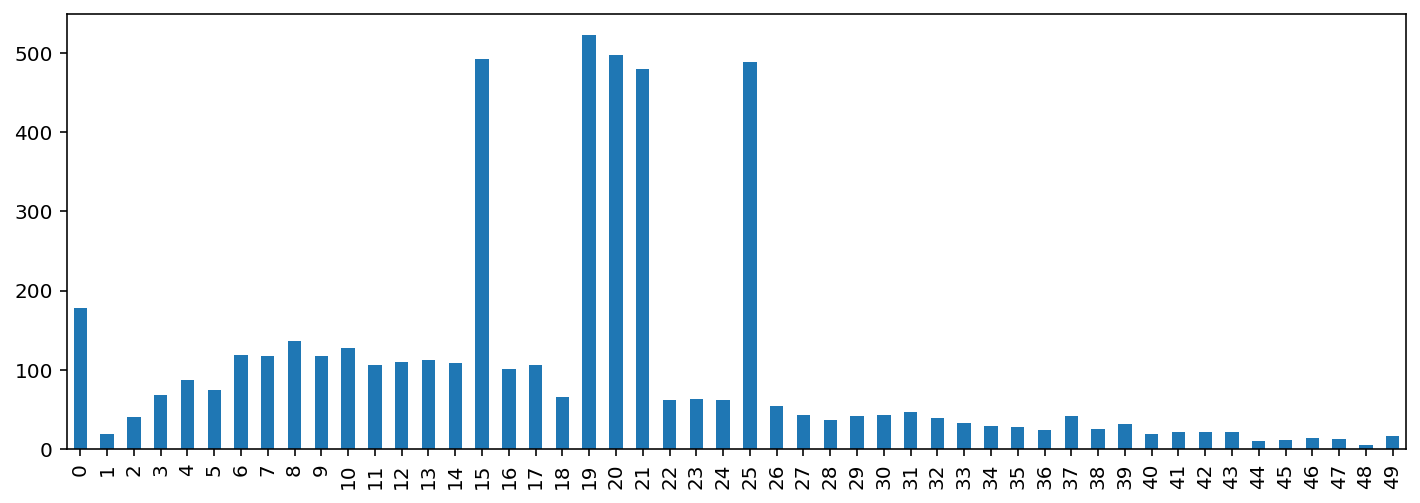

In [91]:
plt.figure(figsize=(12,4))
df_no_err.edges.value_counts().reindex(np.arange(50)).plot.bar(ax=plt.gca());

In [92]:
df_no_err["shapes-edges"] = df_no_err.shapes.map(str) + "-" + df_no_err.edges.map(str)
se_vc = df_no_err["shapes-edges"].value_counts()
se_vc.sort_values(ascending=False).head(20)

17-19    445
20-20    445
22-25    440
23-21    420
16-15    415
0-0      135
5-4       43
9-9       39
8-8       38
4-3       37
9-8       32
10-10     27
9-6       26
8-7       26
6-6       25
6-5       24
19-16     23
9-10      22
10-7      22
7-7       22
Name: shapes-edges, dtype: int64

In [97]:
cutoff = len(df_no_err) / 50
print(cutoff)
outliers = se_vc[se_vc > cutoff].index.tolist()
if "0-0" not in outliers:
    outliers.append("0-0")
outliers

108.6


['17-19', '20-20', '22-25', '23-21', '16-15', '0-0']

In [98]:
mask = ~df_no_err["shapes-edges"].isin(outliers)
df_no_err.loc[mask].reset_index()["fname"].to_csv("fnames.csv", index=False, header=False)